In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [32]:
df = pd.read_csv("../data/5_min_combined_data/COMBINED_DATA/adanient.csv").set_index("datetime").drop(columns="timestamp")
print(len(df.columns))
df.head()


5


,open,high,low,close,volume
datetime,,,,,
2024-12-02 09:20:00+05:30,2415.33,2431.47,2383.38,2393.66,295276
2024-12-02 09:25:00+05:30,2394.09,2406.60,2390.99,2401.17,142623
2024-12-02 09:30:00+05:30,2401.85,2404.32,2381.59,2387.50,115071
2024-12-02 09:35:00+05:30,2387.26,2412.03,2386.00,2410.24,141958
2024-12-02 09:40:00+05:30,2410.48,2411.35,2399.04,2405.29,73237


#### Target Engineering

In [33]:
df["log_ret"] = np.log(df["close"] / df["close"].shift(1))

df["future_3bar_ret"] = (
      df["log_ret"].shift(-1)
    + df["log_ret"].shift(-2)
    + df["log_ret"].shift(-3)
)


In [34]:
df = df.dropna(how="any")

In [35]:
vol = df["log_ret"].std()

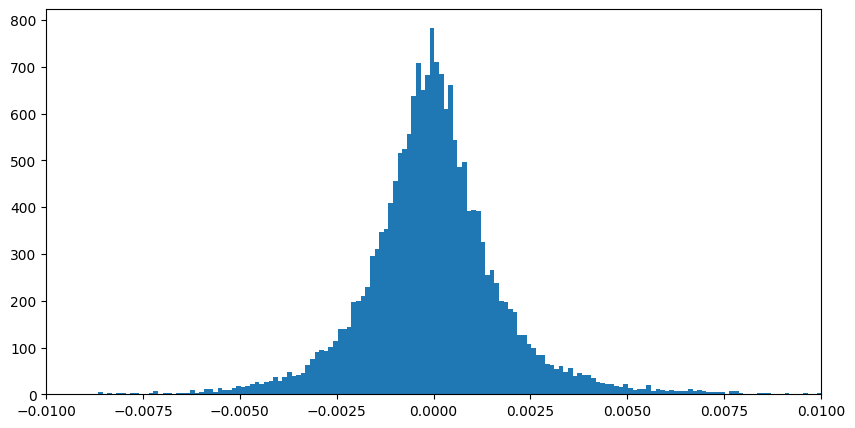

In [36]:
plt.figure(figsize=(10,5))
plt.hist(df["log_ret"], bins=1000)
plt.xlim(-0.01, 0.01)   # zoom into the useful region
plt.show()


In [37]:
vol = df["log_ret"].std()
vol

np.float64(0.0021463017636501)

In [38]:
threshold = 0.25 * df["log_ret"].std()
df["future_1bar_ret"] = df["log_ret"].shift(-1)


df["ternary"] = 0
df.loc[df["future_1bar_ret"] >  threshold, "ternary"] = 1
df.loc[df["future_1bar_ret"] < -threshold, "ternary"] = -1


In [39]:
df["ternary"].value_counts()

ternary
-1    6476
 0    6120
 1    5938
Name: count, dtype: int64

<p style="color: yellow; font-size:20px"> Feature 1 - Relative Volume (Volume Spike)</p>

In [40]:
df["vol_20ma"] = df["volume"].rolling(20).mean()
df["volume_spike"] = df["volume"]/df["vol_20ma"]
df["volume_spike"]=df["volume_spike"].fillna(1.0 )

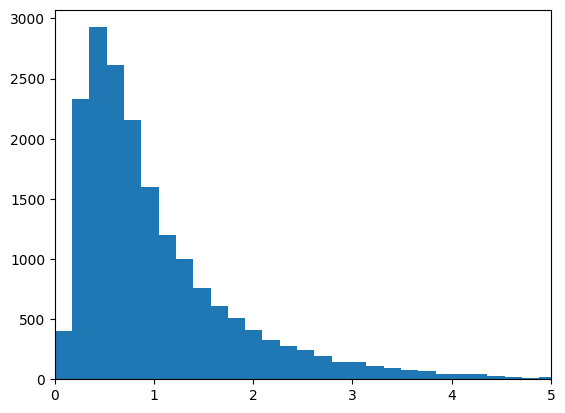

In [41]:
plt.hist(df["volume_spike"], bins=100)
plt.xlim(0, 5)  # zoom into meaningful region
plt.show()


In [42]:
df.head()

,open,high,low,close,volume,log_ret,future_3bar_ret,future_1bar_ret,ternary,vol_20ma,volume_spike
datetime,,,,,,,,,,,
2024-12-02 09:25:00+05:30,2394.09,2406.60,2390.99,2401.17,142623,0.003133,0.001714,-0.005709,-1,NaN,1.0
2024-12-02 09:30:00+05:30,2401.85,2404.32,2381.59,2387.50,115071,-0.005709,0.003792,0.009480,1,NaN,1.0
2024-12-02 09:35:00+05:30,2387.26,2412.03,2386.00,2410.24,141958,0.009480,-0.002963,-0.002056,-1,NaN,1.0
2024-12-02 09:40:00+05:30,2410.48,2411.35,2399.04,2405.29,73237,-0.002056,-0.006427,-0.003632,-1,NaN,1.0
2024-12-02 09:45:00+05:30,2405.15,2405.58,2395.60,2396.57,48008,-0.003632,-0.001620,0.002725,1,NaN,1.0


#### Creating data for model

In [43]:
X = df[["volume_spike"]]
y = df["ternary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

#### Training the model

In [44]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, shuffle=False)

#### Logistic Regression model

In [45]:
model = LogisticRegression(max_iter=500)

In [46]:
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [47]:
accuracy_score(y_train,model.predict(X_train))

0.35131854050043837

In [48]:
accuracy_score(y_test,model.predict(X_test))

0.3514971675209064

In [49]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.35      0.97      0.51      1280
           0       0.51      0.04      0.07      1356
           1       0.31      0.01      0.02      1071

    accuracy                           0.35      3707
   macro avg       0.39      0.34      0.20      3707
weighted avg       0.39      0.35      0.21      3707



#### Using Decision Tree 

In [50]:
# Step 1: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

# Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [51]:
model = DecisionTreeClassifier(max_depth=5)

In [52]:
model.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [53]:
accuracy_score(y_train,model.predict(X_train))

0.3697841726618705

In [54]:
accuracy_score(y_val,model.predict(X_val))

0.3299163744267602

In [55]:
accuracy_score(y_test,model.predict(X_test))

0.3485298084704613

In [56]:
depth_hyperparams = range(1,50,2)

In [57]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.36133093525179855]
Validation Accuracy Scores: [0.3177771783113029]
Training Accuracy Scores: [0.36133093525179855, 0.36492805755395685]
Validation Accuracy Scores: [0.3177771783113029, 0.32856757485837607]
Training Accuracy Scores: [0.36133093525179855, 0.36492805755395685, 0.3697841726618705]
Validation Accuracy Scores: [0.3177771783113029, 0.32856757485837607, 0.3299163744267602]
Training Accuracy Scores: [0.36133093525179855, 0.36492805755395685, 0.3697841726618705]
Validation Accuracy Scores: [0.3177771783113029, 0.32856757485837607, 0.3299163744267602]
Training Accuracy Scores: [0.36133093525179855, 0.36492805755395685, 0.3697841726618705]
Validation Accuracy Scores: [0.3177771783113029, 0.32856757485837607, 0.3299163744267602]
Training Accuracy Scores: [0.36133093525179855, 0.36492805755395685, 0.3697841726618705]
Validation Accuracy Scores: [0.3177771783113029, 0.32856757485837607, 0.3299163744267602]
Training Accuracy Scores: [0.36133093525179855, 

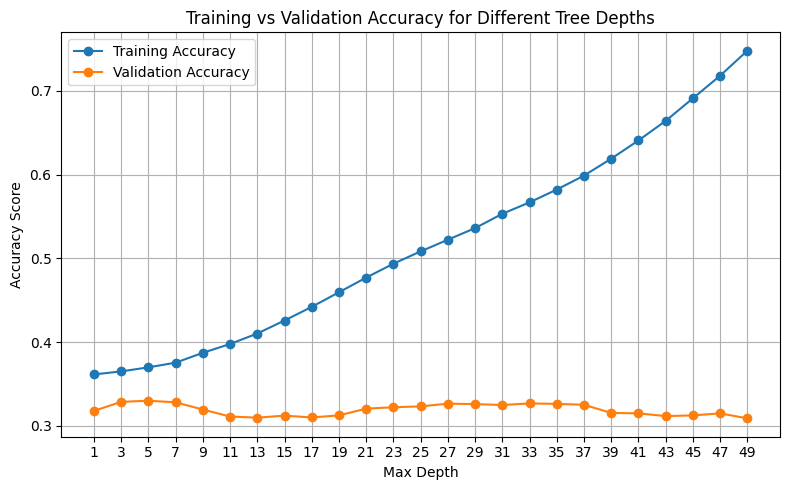

In [58]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()


In [59]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.35      0.85      0.49      1280
           0       0.43      0.10      0.16      1356
           1       0.25      0.06      0.10      1071

    accuracy                           0.35      3707
   macro avg       0.35      0.34      0.25      3707
weighted avg       0.35      0.35      0.26      3707



In [60]:
# After fitting with max_depth=1
tree = model.tree_

# Get the feature used in the root split
feature_idx = tree.feature[0]
feature_name = X_train.columns[feature_idx]
threshold = tree.threshold[0]

print(f"Feature: {feature_name}")
print(f"Threshold: {threshold:.4f}")

Feature: volume_spike
Threshold: 0.7450
